## Load PDF Documents


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

In [2]:
"""
Loading PDF documents from Google Drive

Imp: Documents.zip should be in Google Drive.
"""

from google.colab import drive

# A new small window will appear asking for permission, Click yes and give all permissions
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!mkdir Documents
!unzip  "/content/drive/MyDrive/Documents.zip"

Archive:  /content/drive/MyDrive/Documents.zip
  inflating: Documents/StormsEanexplanat.pdf  
  inflating: __MACOSX/Documents/._StormsEanexplanat.pdf  
  inflating: Documents/.DS_Store     
  inflating: __MACOSX/Documents/._.DS_Store  
  inflating: Documents/Scaramuzzitenyearsof.pdf  
  inflating: __MACOSX/Documents/._Scaramuzzitenyearsof.pdf  
  inflating: Documents/OgawaHcorrelatio.pdf  
  inflating: __MACOSX/Documents/._OgawaHcorrelatio.pdf  
  inflating: Documents/Scaramuzzigasloading.pdf  
  inflating: __MACOSX/Documents/._Scaramuzzigasloading.pdf  
  inflating: Documents/HuangBJwatercantr.pdf  
  inflating: __MACOSX/Documents/._HuangBJwatercantr.pdf  
  inflating: Documents/BiberianJPdeuteriumg.pdf  
  inflating: __MACOSX/Documents/._BiberianJPdeuteriumg.pdf  
  inflating: Documents/MizunoTanomalousia.pdf  
  inflating: __MACOSX/Documents/._MizunoTanomalousia.pdf  
  inflating: Documents/ChiceaDonneweleme.pdf  
  inflating: __MACOSX/Documents/._ChiceaDonneweleme.pdf  
  inflating

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

DOCUMENTS = list(Path("Documents").rglob("*.pdf"))
# DOCUMENTS = sorted(DOCUMENTS, key=lambda x: x.name)

print(f"Total Documents: {len(DOCUMENTS)}")

Total Documents: 15


## Plot File Sizes

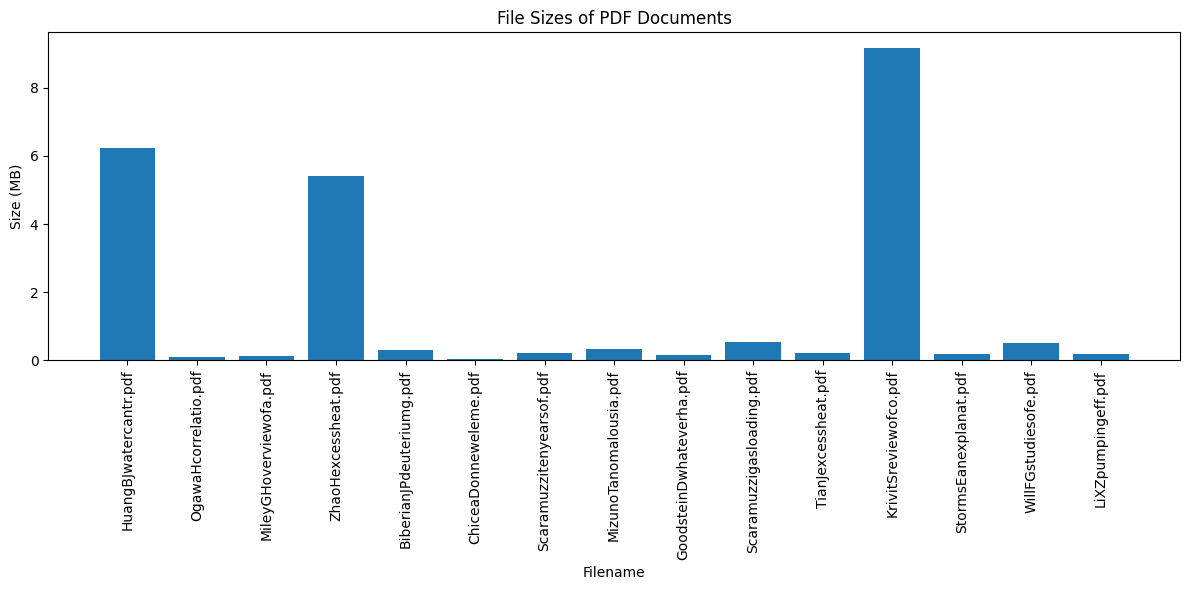

In [5]:

# Get size of PDF Files
file_sizes = {}
for doc_path in DOCUMENTS:
  file_sizes[doc_path.name] = doc_path.stat().st_size


# Create a pandas Series from the file_sizes dictionary
file_sizes_series = pd.Series(file_sizes)
# Convert the Series to a DataFrame, resetting the index
file_sizes_df = file_sizes_series.reset_index()
# Rename the columns
file_sizes_df.columns = ['Filename', 'Size (bytes)']
# Convert 'Size (bytes)' to megabytes
file_sizes_df['Size (MB)'] = file_sizes_df['Size (bytes)'] / (1024 * 1024)

# Plot the File Sizes
plt.figure(figsize=(12, 6))
plt.bar(file_sizes_df['Filename'], file_sizes_df['Size (MB)'])
plt.xlabel('Filename')
plt.ylabel('Size (MB)')
plt.title('File Sizes of PDF Documents')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Extract Text from PDFs

In [6]:
!pip install pymupdf pytesseract

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 104.9 MB/s eta 0:00:00


In [7]:
import fitz
import pytesseract
from PIL import Image
from typing import Dict

OCR_DPI = 250
OCR_LANG = "eng"
OCR_CONFIG = "--psm 6"

def _page_to_image(page: fitz.Page, dpi: int = OCR_DPI) -> Image.Image:
    """Render a PDF page to a Pillow image at the desired DPI."""
    scale = dpi / 72  # PDF points are 1/72 inch
    pix = page.get_pixmap(matrix=fitz.Matrix(scale, scale), alpha=False)
    mode = "RGB" if pix.n < 4 else "RGBA"
    return Image.frombytes(mode, (pix.width, pix.height), pix.samples)


def ocr_pdf(pdf_path: Path) -> Dict[int, str]:
    """
    Reads the content of a PDF page by page using Tesseract OCR.
    """
    res: Dict[int, str] = {}
    with fitz.open(pdf_path) as doc:
        for page_index in range(doc.page_count):
            page = doc.load_page(page_index)
            image = _page_to_image(page)
            text = pytesseract.image_to_string(image, lang=OCR_LANG, config=OCR_CONFIG)
            res[page_index + 1] = text.strip()
    return res

def extract_text_from_pdf(pdf_file_path: Path) -> Dict[int, str]:
    """
    Reads the content of a PDF page by page using PyMuPDF.
    """
    text = {}
    try:
        pdf_document = fitz.open(pdf_file_path)
        for no in range(len(pdf_document)):
            page = pdf_document.load_page(no)
            text[no+1] = page.get_text() if page.get_text() else ""
        return text
    except Exception as e:
        print(f"Failed to read PDF file {pdf_file_path}: {e}")
        return {}

In [8]:
# Utility Function
import json

def write_json(
    output_fn: str | Path,
    data: Dict,
) -> Path:
    """
    Dump data to a JSON file.
    """
    output_fn = Path(output_fn)
    output_fn.parent.mkdir(exist_ok=True, parents=True)
    with output_fn.open('w', encoding='utf-8') as f:
        json.dump(data, f, indent=2, ensure_ascii=False)
    return output_fn

In [9]:
from tqdm import tqdm
from pathlib import Path

GOOGLE_DRIVE_PATH = Path('/content/drive/MyDrive/Topic_Modeling')

# Extract PDFs using pymupdf
pymupdf_output = {}
for doc_path in tqdm(DOCUMENTS, desc="Extracting PDFs using pymupdf..."):
    pages: dict[int, str] = extract_text_from_pdf(doc_path)
    pymupdf_output[doc_path.stem] = "".join(pages.values())

write_json(GOOGLE_DRIVE_PATH / "pymupdf_output.json", pymupdf_output)

Extracting PDFs using pymupdf...: 100%|██████████| 15/15 [00:02<00:00,  7.45it/s]


PosixPath('/content/drive/MyDrive/Topic_Modeling/pymupdf_output.json')

In [10]:
# OCR PDFs using tesseract
tesseract_output = {}
for doc_path in tqdm(DOCUMENTS, desc="Extracting PDFs using tesseract output..."):
    pages: dict[int, str] = ocr_pdf(doc_path)
    tesseract_output[doc_path.stem] = "".join(pages.values())

write_json(GOOGLE_DRIVE_PATH / "tesseract_output.json", tesseract_output)

Extracting PDFs using tesseract output...: 100%|██████████| 15/15 [33:41<00:00, 134.79s/it]


PosixPath('/content/drive/MyDrive/Topic_Modeling/tesseract_output.json')

# PyMuPDF (fitz) vs. Tesseract OCR Output

For the purpose of **automated data extraction and analysis of digitally-created PDFs, PyMuPDF (fitz) is superior.**

The critical distinction lies in the nature of the errors:

1.  **PyMuPDF Errors are Systematic and Repairable:** PyMuPDF extracts the **correct character set** (e.g., `C`, `u`, `6`, `3`). The error is purely **structural**—the elements are separated (`Cu 63`). This separation can be fixed using simple, automated scripting (e.g., regular expressions) to reformat the notation. The original, accurate data is preserved.
2.  **Tesseract Errors are Recognition-based and Irrecoverable:** Tesseract often **loses the correct data** by misidentifying the characters (e.g., substituting `63` with `“`). Once the correct character is replaced by an incorrect one, there is no reliable way to automatically recover the original, accurate number or symbol.

Despite the messier initial output and the need to fix systematic notation errors, the **underlying text data from PyMuPDF is more trustworthy and repairable** than the error-prone character recognition output from Tesseract OCR.

## Split into Paragraphs/Chunks

In [11]:
import re
from typing import List

import spacy
from spacy.language import Language

nlp = spacy.load("en_core_web_sm")

def split_to_paras(text:str)->list[str]:
    """
    Split text into paragraphs with more than two newlines
    """
    text = re.sub(r'[ \t]*\n[ \t]*', '\n', text)
    return [para.strip() for para in re.split(r'\n{2,}', text) if para.strip()]

def split_to_chunks_with_spacy(text: str, max_count: int = 10) -> list[str]:
    """
    1. Split text into sentences with Spacy
    2. Join sentences into chunks of max_count sentences
    """
    doc = nlp(text)
    sentences = [sent.text.strip() for sent in doc.sents if sent.text.strip()]

    # Group sentences into chunks
    chunks = []
    for i in range(0, len(sentences), max_count):
        chunk = ' '.join(sentences[i:i + max_count])
        chunks.append(chunk)

    return chunks

CHUNKING METHODS COMPARISON
            Document  Newline Chunks  spaCy Chunks
   HuangBJwatercantr               2            37
    OgawaHcorrelatio              20             7
  MileyGHoverviewofa              35            22
     ZhaoHexcessheat              75            51
BiberianJPdeuteriumg              46             9
   ChiceaDonneweleme               1            14
Scaramuzzitenyearsof              60            33
  MizunoTanomalousia               2            16
GoodsteinDwhateverha              47            32
Scaramuzzigasloading               1            31
     TianJexcessheat               1            16
   KrivitSreviewofco               1            78
   StormsEanexplanat               1           129
    WillFGstudiesofe              24            19
      LiXZpumpingeff              31            16

SUMMARY STATISTICS:
Total Documents: 15

Newline Method:
  Total Chunks: 347
  Average Chunks per Doc: 23.1

spaCy Method:
  Total Chunks: 510
  Average Ch

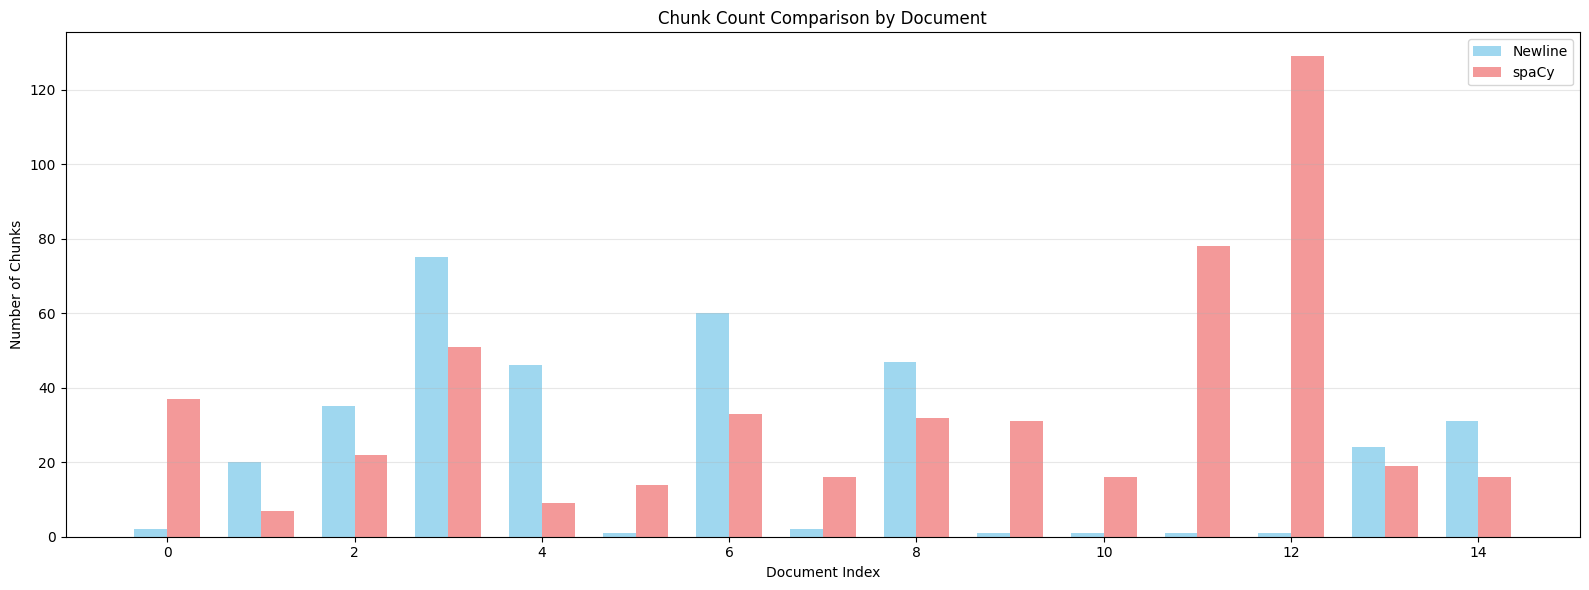

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Copy the better result from previous step (Extracting text from PDFs)
docs_text = pymupdf_output

# Split text with double new lines
newline_chunks = {}
for doc_name, text in docs_text.items():
    newline_chunks[doc_name] = split_to_paras(text)  # Using newline splitting

# Split text with spaCy
spacy_chunks = {}
for doc_name, text in docs_text.items():
    spacy_chunks[doc_name] = split_to_chunks_with_spacy(text)

# Create comparison data
comparison_data = []
for doc_name in docs_text.keys():
    newline_count = len(newline_chunks.get(doc_name, []))
    spacy_count = len(spacy_chunks.get(doc_name, []))

    comparison_data.append({
        'Document': doc_name,
        'Newline Chunks': newline_count,
        'spaCy Chunks': spacy_count
    })

# Create DataFrame
df_comparison = pd.DataFrame(comparison_data)

# Display the table
print("=" * 100)
print("CHUNKING METHODS COMPARISON")
print("=" * 100)
print(df_comparison.to_string(index=False))
print("=" * 100)

# Summary statistics
print("\nSUMMARY STATISTICS:")
print(f"Total Documents: {len(df_comparison)}")
print(f"\nNewline Method:")
print(f"  Total Chunks: {df_comparison['Newline Chunks'].sum()}")
print(f"  Average Chunks per Doc: {df_comparison['Newline Chunks'].mean():.1f}")
print(f"\nspaCy Method:")
print(f"  Total Chunks: {df_comparison['spaCy Chunks'].sum()}")
print(f"  Average Chunks per Doc: {df_comparison['spaCy Chunks'].mean():.1f}")

# Visualization - Chunk Count Comparison Only
fig, ax = plt.subplots(1, 1, figsize=(16, 6))

x = range(len(df_comparison))
width = 0.35
ax.bar([i - width/2 for i in x], df_comparison['Newline Chunks'],
       width, label='Newline', alpha=0.8, color='skyblue')
ax.bar([i + width/2 for i in x], df_comparison['spaCy Chunks'],
       width, label='spaCy', alpha=0.8, color='lightcoral')
ax.set_xlabel('Document Index')
ax.set_ylabel('Number of Chunks')
ax.set_title('Chunk Count Comparison by Document')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


## Clean Text

In [13]:
import spacy
from spacy.language import Language
nlp = spacy.load("en_core_web_sm")

In [14]:
import re
from typing import Iterable, List

URL_PATTERN = re.compile(r'https?://\S+|www\.\S+')
EMAIL_PATTERN = re.compile(r'\b[\w.+-]+@[\w-]+\.[\w.-]+\b')
HTML_TAG_PATTERN = re.compile(r'<[^>]+>')
NON_ALPHA_PATTERN = re.compile(r'[^a-z\s]')
MULTISPACE_PATTERN = re.compile(r'\s+')
EXTRA_STOPWORDS = {'figure', 'fig', 'et', 'al', 'table', 'https', 'www'}

STOP_WORDS = nlp.Defaults.stop_words.union(EXTRA_STOPWORDS)
MIN_TOKEN_LEN = 2

def normalize_text(text: str) -> str:
    if not text:
        return ''
    text = text.lower()
    text = HTML_TAG_PATTERN.sub(' ', text)
    text = URL_PATTERN.sub(' ', text)
    text = EMAIL_PATTERN.sub(' ', text)
    text = NON_ALPHA_PATTERN.sub(' ', text)
    text = MULTISPACE_PATTERN.sub(' ', text).strip()
    return text

def clean_text(text: str) -> str:
    text = normalize_text(text)
    if not text:
        return ''
    doc = nlp(text)
    toks = []
    for tok in doc:
        if tok.is_stop or tok.is_punct or tok.like_num:
            continue
        lemma = (tok.lemma_ or tok.text).lower().strip()
        if len(lemma) < MIN_TOKEN_LEN or lemma in STOP_WORDS:
            continue
        toks.append(lemma)
    return ' '.join(toks)



In [15]:
cleaned_doc_chunks = {}

for doc_name, chunks in spacy_chunks.items():
    cleaned_doc_chunks[doc_name] = [clean_text(c) for c in chunks]

write_json(GOOGLE_DRIVE_PATH / "cleaned_doc_chunks.json", cleaned_doc_chunks)

PosixPath('/content/drive/MyDrive/Topic_Modeling/cleaned_doc_chunks.json')

In [16]:

def clean_texts(chunks: List[str]) -> List[str]:
    out = []
    for c in chunks:
        if isinstance(c, str) and c.strip():
            cc = clean_text(c)
            if cc:
                out.append(cc)
    return out

# Build cleaned_doc_chunks as dict[str, list[str]]
cleaned_doc_chunks = {
    doc_name: clean_texts(chunks)
    for doc_name, chunks in spacy_chunks.items()
}

# quick sanity print
for k, v in list(cleaned_doc_chunks.items())[:3]:
    print(k, "→", len(v), "clean paragraphs")


HuangBJwatercantr → 37 clean paragraphs
OgawaHcorrelatio → 7 clean paragraphs
MileyGHoverviewofa → 22 clean paragraphs


**Flatten cleaned paragraphs into a DataFrame**

In [17]:
import pandas as pd
import numpy as np

assert 'cleaned_doc_chunks' in globals(), "cleaned_doc_chunks not found. Run the earlier extraction + cleaning cells."

tfidf_rows = []
for doc_name, chunks in cleaned_doc_chunks.items():
    for i, txt in enumerate(chunks):
        if isinstance(txt, str) and len(txt.strip()) > 0:
            tfidf_rows.append({'doc_name': doc_name, 'paragraph_index': i, 'text': txt})

tfidf_df = pd.DataFrame(tfidf_rows)
print("Paragraphs for TF-IDF:", len(tfidf_df))


Paragraphs for TF-IDF: 510


**TF-IDF vectorization (1–2-grams)**

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1,2),
    min_df=2
)

X_tfidf = tfidf_vectorizer.fit_transform(tfidf_df['text'])
print("TF-IDF shape:", X_tfidf.shape)


TF-IDF shape: (510, 6781)


**Reduce to dense vectors with TruncatedSVD (and L2-normalize)**

In [19]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer

svd_components = 128  # try 64/128/256 if you want
svd = TruncatedSVD(n_components=svd_components, random_state=42)
X_tfidf_svd = svd.fit_transform(X_tfidf)  # dense [n_paras, svd_components]

# L2 normalize for cosine/IP-friendly downstream
X_tfidf_svd = Normalizer(copy=False).fit_transform(X_tfidf_svd)
X_tfidf_svd.shape


(510, 128)

**PCA & t-SNE plots**

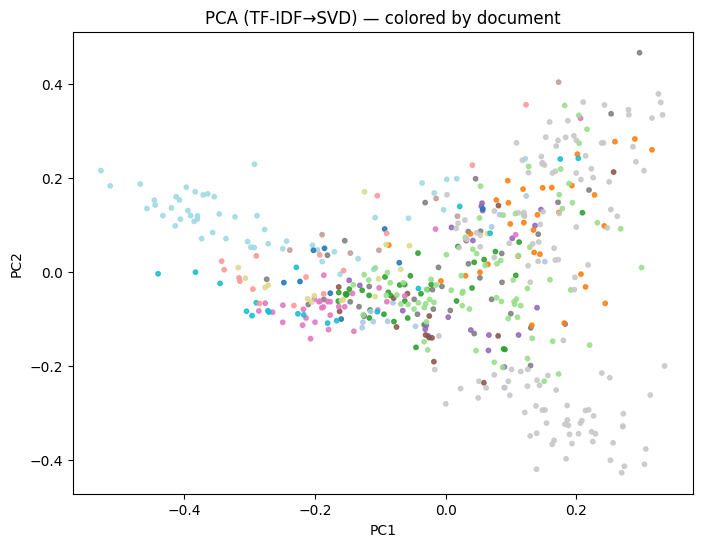

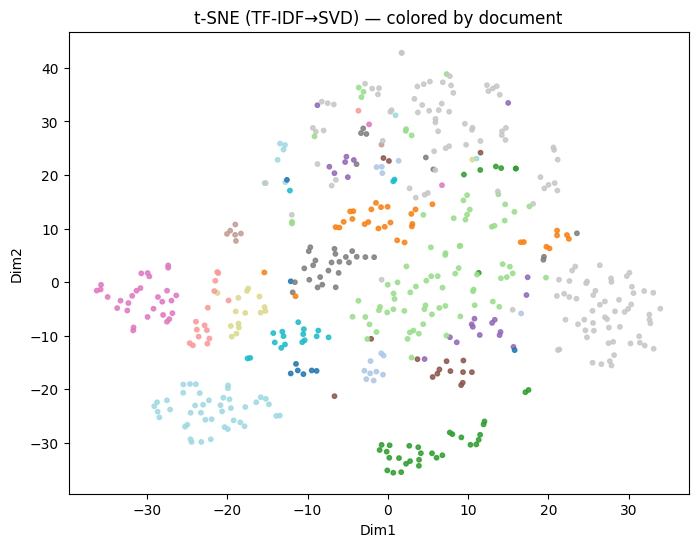

In [20]:
# PCA & t-SNE plots (colored by document)
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D

# Make sure tfidf_df has columns: doc_name, paragraph_index, text
assert {'doc_name', 'paragraph_index', 'text'}.issubset(tfidf_df.columns)

# Encode document names as categorical codes for coloring
docs_cat = tfidf_df['doc_name'].astype('category')
doc_codes = docs_cat.cat.codes.values              # [0..#docs-1] per row (paragraph)
doc_names = list(docs_cat.cat.categories)          # index -> doc_name

# ---------- PCA ----------
pca2 = PCA(n_components=2, random_state=42)
X_tfidf_pca2 = pca2.fit_transform(X_tfidf_svd)

plt.figure(figsize=(8,6))
sc = plt.scatter(
    X_tfidf_pca2[:, 0], X_tfidf_pca2[:, 1],
    c=doc_codes, cmap='tab20', s=10, alpha=0.85
)
plt.title("PCA (TF-IDF→SVD) — colored by document")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

# Build a compact legend (cap at 20 docs to avoid clutter)
max_legend = 20
unique_codes = np.unique(doc_codes)
legend_codes = unique_codes[:max_legend]

legend_elements = [
    Line2D([0],[0], marker='o', linestyle='',
           markerfacecolor=plt.cm.tab20((int(c) % 20)/20.0),
           markeredgecolor='none', markersize=6,
           label=doc_names[int(c)])
    for c in legend_codes
]
if len(unique_codes) > max_legend:
    legend_elements.append(Line2D([0],[0], marker='o', linestyle='',
                                  markerfacecolor='lightgray',
                                  markeredgecolor='none', markersize=6,
                                  label=f"+{len(unique_codes)-max_legend} more"))
plt.figure(figsize=(8,0.01))  # dummy figure just to show legend if you want it separately
plt.legend(handles=legend_elements, ncol=4, frameon=False, loc='center')
plt.axis('off')
plt.close()

# ---------- t-SNE ----------
tsne = TSNE(n_components=2, random_state=42, init='pca', perplexity=30, learning_rate='auto')
X_tfidf_tsne2 = tsne.fit_transform(X_tfidf_svd)

plt.figure(figsize=(8,6))
plt.scatter(
    X_tfidf_tsne2[:, 0], X_tfidf_tsne2[:, 1],
    c=doc_codes, cmap='tab20', s=10, alpha=0.85
)
plt.title("t-SNE (TF-IDF→SVD) — colored by document")
plt.xlabel("Dim1"); plt.ylabel("Dim2")
plt.show()


K-means on TF-IDF/SVD + silhouette helper

,k,inertia_mean,inertia_std,sil_mean,sil_std
0,3,452.210979,1.071835,0.030362,0.002434
1,4,443.934130,1.241754,0.034340,0.003088
2,5,434.537635,1.105912,0.040095,0.002304
3,6,426.496531,1.972784,0.046200,0.003661
4,7,419.901468,2.442190,0.049289,0.004092
5,8,414.163247,2.455474,0.051739,0.004848
6,9,408.918085,1.036788,0.054062,0.002323
7,10,403.001465,1.304727,0.057682,0.002670
8,11,400.064922,1.197458,0.057263,0.003185
9,12,396.307638,2.170248,0.058023,0.003690


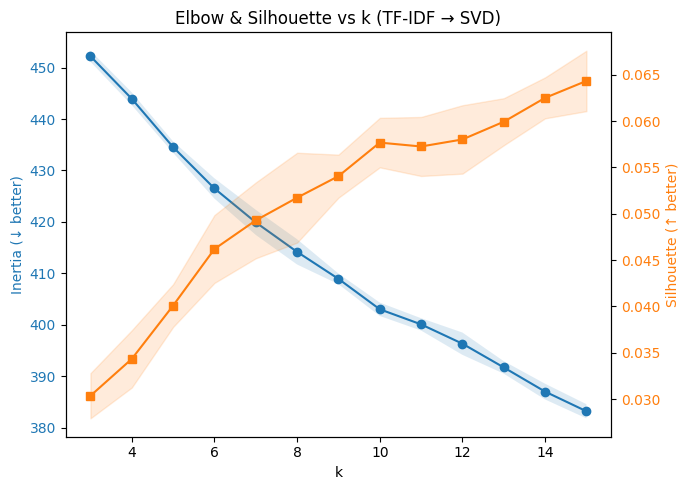

Suggested k = 15  (sil_mean=0.064, inertia_mean=383)


In [21]:
# K sweep: inertia (elbow) + silhouette (averaged over seeds), plot, and suggest K
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

X = X_tfidf_svd                              # normalized 128-d SVD vectors
K_RANGE = range(3, 16)                       # change if needed
SEEDS   = [0, 1, 2, 3, 42]                   # small seed set for stability
SIL_SAMPLE = None                            # set e.g. 5000 if your dataset is very large

def eval_k(X, k_range, seeds, sil_sample=None):
    n = X.shape[0]
    idx = np.arange(n) if (sil_sample is None or n <= sil_sample) \
          else np.random.RandomState(42).choice(n, size=sil_sample, replace=False)
    rows = []
    for k in k_range:
        inertias, sils = [], []
        for s in seeds:
            km = KMeans(n_clusters=k, random_state=s, n_init='auto')
            labels = km.fit_predict(X)
            inertias.append(km.inertia_)
            sils.append(silhouette_score(X[idx], labels[idx]))
        rows.append([k, np.mean(inertias), np.std(inertias), np.mean(sils), np.std(sils)])
    return pd.DataFrame(rows, columns=["k","inertia_mean","inertia_std","sil_mean","sil_std"])

kres = eval_k(X, K_RANGE, SEEDS, SIL_SAMPLE)
display(kres)

# plot
fig, ax1 = plt.subplots(figsize=(7,5))
ax1.plot(kres.k, kres.inertia_mean, marker="o")
ax1.fill_between(kres.k, kres.inertia_mean - kres.inertia_std, kres.inertia_mean + kres.inertia_std, alpha=0.15)
ax1.set_xlabel("k"); ax1.set_ylabel("Inertia (↓ better)", color="C0"); ax1.tick_params(axis='y', labelcolor="C0")
ax2 = ax1.twinx()
ax2.plot(kres.k, kres.sil_mean, color="C1", marker="s")
ax2.fill_between(kres.k, kres.sil_mean - kres.sil_std, kres.sil_mean + kres.sil_std, alpha=0.15, color="C1")
ax2.set_ylabel("Silhouette (↑ better)", color="C1"); ax2.tick_params(axis='y', labelcolor="C1")
ax1.set_title("Elbow & Silhouette vs k (TF-IDF → SVD)"); plt.tight_layout(); plt.show()

# suggest K = highest silhouette; tie-break by lower inertia
best = kres.sort_values(["sil_mean","inertia_mean"], ascending=[False, True]).iloc[0]
SUGGESTED_K = int(best.k)
print(f"Suggested k = {SUGGESTED_K}  (sil_mean={best.sil_mean:.3f}, inertia_mean={best.inertia_mean:.0f})")


,count
cluster,
0,48
1,24
2,22
3,28
4,26
5,35
6,24
7,36
8,14


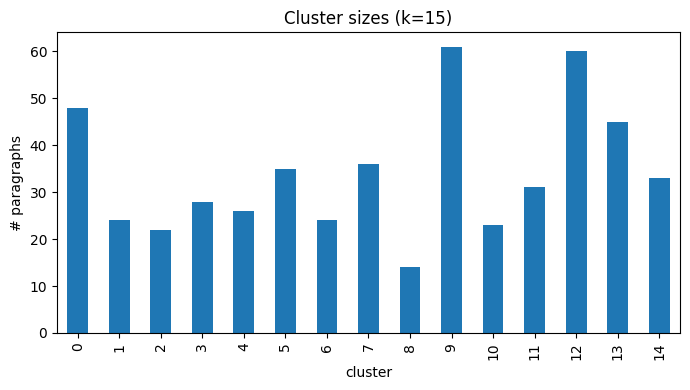

In [22]:
# Fit once with suggested K and show sizes
from sklearn.cluster import KMeans
N_CLUSTERS_TFIDF = SUGGESTED_K  # override manually if your sanity check suggests otherwise

kmeans_tfidf = KMeans(n_clusters=N_CLUSTERS_TFIDF, random_state=42, n_init='auto')
labels_tfidf = kmeans_tfidf.fit_predict(X_tfidf_svd)
tfidf_df["cluster"] = labels_tfidf

sizes = tfidf_df["cluster"].value_counts().sort_index()
display(sizes)

# warn on tiny clusters (often junky)
MIN_SIZE = max(3, int(0.01 * len(tfidf_df)))
tiny = sizes[sizes < MIN_SIZE]
if len(tiny):
    print("\n⚠️ Tiny clusters detected (consider smaller k or merging):")
    display(tiny)

# (optional) quick sizes plot
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
sizes.plot(kind="bar")
plt.title(f"Cluster sizes (k={N_CLUSTERS_TFIDF})"); plt.xlabel("cluster"); plt.ylabel("# paragraphs")
plt.tight_layout(); plt.show()


Class-based TF-IDF per cluster + 3 representative paragraphs

In [23]:
from sklearn.metrics.pairwise import cosine_distances
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Class-based TF-IDF: one big string per cluster
cluster_texts = tfidf_df.groupby('cluster')['text'].apply(lambda xs: ' '.join(xs)).tolist()

cb_vectorizer = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.90,
    token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z\-]{3,}\b"  # tokens must be 4+ chars
)

CB = cb_vectorizer.fit_transform(cluster_texts)
vocab = np.array(cb_vectorizer.get_feature_names_out())
DOMAIN_STOP = {"fig","table","section","experiment", "press conference", "conference", "open"
}

def top_keywords_sparse_row_nonredundant(row, vocab, k=6):
    # get indices and weights without densifying
    data = row.data
    idxs = row.indices
    if data.size == 0:
        return []

    # sort terms by weight descending
    order = np.argsort(-data)
    terms = vocab[idxs[order]]

    picked = []
    for term in terms:
        t = term.strip()
        if t in DOMAIN_STOP:
            continue
        # skip if term is substring of an already picked phrase,
        # or if an already picked phrase is a substring of this term
        if any(t in s or s in t for s in picked):
            continue
        picked.append(t)
        if len(picked) == k:
            break
    return picked

cluster_keywords = [top_keywords_sparse_row_nonredundant(CB.getrow(i), vocab, 6)
                    for i in range(CB.shape[0])]

# Representatives: nearest to TF-IDF SVD centroid via cosine distance
centroids = kmeans_tfidf.cluster_centers_
def top_n_to_centroid(centroid, X, n=3):
    dists = cosine_distances(X, centroid.reshape(1,-1)).ravel()
    idx = np.argsort(dists)[:n]
    return idx

rep_rows = []
for c in range(N_CLUSTERS_TFIDF):
    idxs = np.where(tfidf_df['cluster'].values == c)[0]
    if len(idxs)==0:
        rep_rows.append({'cluster': c, 'keywords': cluster_keywords[c], 'representatives': []})
        continue
    subX = X_tfidf_svd[idxs]
    top_local = top_n_to_centroid(centroids[c], subX, n=min(3, len(idxs)))
    reps = tfidf_df.iloc[idxs[top_local]][['doc_name','paragraph_index']].to_dict('records')
    rep_rows.append({'cluster': c, 'keywords': cluster_keywords[c], 'representatives': reps})

cluster_summary_tfidf = pd.DataFrame(rep_rows)
cluster_summary_tfidf


,cluster,keywords,representatives
0,0,"[fusion, cold, scaramuzzi, nucleus, science, n...","[{'doc_name': 'GoodsteinDwhateverha', 'paragra..."
1,1,"[open electrolytic, reflux open, heat liod, li...","[{'doc_name': 'ZhaoHexcessheat', 'paragraph_in..."
2,2,"[widom, larsen, neutron, lenrs, theory, nucleus]","[{'doc_name': 'KrivitSreviewofco', 'paragraph_..."
3,3,"[reactor, signal, tube, isotope, pipe, sample]","[{'doc_name': 'HuangBJwatercantr', 'paragraph_..."
4,4,"[cathode, palladium, perform, analysis, passel...","[{'doc_name': 'KrivitSreviewofco', 'paragraph_..."
5,5,"[isotopic, group, element, transmutation, abun...","[{'doc_name': 'KrivitSreviewofco', 'paragraph_..."
6,6,"[reproducibility, group, community, field, res...","[{'doc_name': 'Scaramuzzitenyearsof', 'paragra..."
7,7,"[fusion, technology, cold, tokyo, internationa...","[{'doc_name': 'StormsEanexplanat', 'paragraph_..."
8,8,"[electric resistance, neutron emission, heat g...","[{'doc_name': 'OgawaHcorrelatio', 'paragraph_i..."
9,9,"[international, fusion, matter, italy, nuclear...","[{'doc_name': 'StormsEanexplanat', 'paragraph_..."


## BERT Embedding

In [24]:
from transformers import BertTokenizer, BertModel
import torch

# Load BERT tokenizer and model from HuggingFace
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')


def get_bert_embedding(text):
    # Tokenize input for BERT
    inputs = bert_tokenizer(text, return_tensors='pt', truncation=True, padding=True)

    # Get BERT outputs
    outputs = bert_model(**inputs)

    # Use pooled output as embedding (CLS token)
    pooled_output = outputs.pooler_output
    return pooled_output.detach()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [25]:
!pip install tqdm

In [27]:
import pickle
from tqdm import tqdm

# Generate BERT Embeddings for the documents
bert_embeddings = []
metadata = []

for doc_name, chunks in tqdm(cleaned_doc_chunks.items(), desc="Generating BERT Embeddings") :
    for i, chunk in enumerate(chunks):
        if chunk.strip():  # Ensure chunks is not empty after cleaning
            embedding = get_bert_embedding(chunk)
            bert_embeddings.append(embedding)
            metadata.append({'doc_name': doc_name, 'chunk_index': i})

bert_embeddings_tensor = torch.cat(bert_embeddings, dim=0)

# Save embeddings and metadata to pickle file
embeddings_data = {
    'embeddings': bert_embeddings_tensor.cpu().numpy(),  # Convert to numpy for smaller file size
    'metadata': metadata,
    'shape': bert_embeddings_tensor.shape,
    'total_chunks': len(metadata)
}

with open('bert_embeddings.pkl', 'wb') as f:
    pickle.dump(embeddings_data, f)

save_path = '/content/drive/MyDrive/Topic_Modeling/bert_embeddings.pkl'
with open(save_path, 'wb') as f:
    pickle.dump(embeddings_data, f)

# Information about the BERT embeddings
print(f"Total number of paragraphs with embeddings: {len(metadata)}")
print(f"Shape of concatenated embeddings tensor: {bert_embeddings_tensor.shape}")


Generating BERT Embeddings: 100%|██████████| 15/15 [03:02<00:00, 12.17s/it]

Total number of paragraphs with embeddings: 510
Shape of concatenated embeddings tensor: torch.Size([510, 768])


Original embedding shape: (510, 768)
Total chunks: 510

PERFORMING PCA REDUCTION
Reduced embedding shape: (510, 2)
Explained variance ratio: [0.5933315  0.11455324]
Total explained variance: 0.7079

PCA results saved successfully!

PERFORMING t-SNE REDUCTION
Running t-SNE (this may take a few minutes)...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 510 samples in 0.002s...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 510 samples in 0.086s...
[t-SNE] Computed conditional probabilities for sample 510 / 510
[t-SNE] Mean sigma: 1.076491
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.500938
[t-SNE] KL divergence after 1000 iterations: 0.884786

Reduced embedding shape: (510, 2)
Final KL divergence: 0.8848

t-SNE results saved successfully!

CREATING VISUALIZATIONS


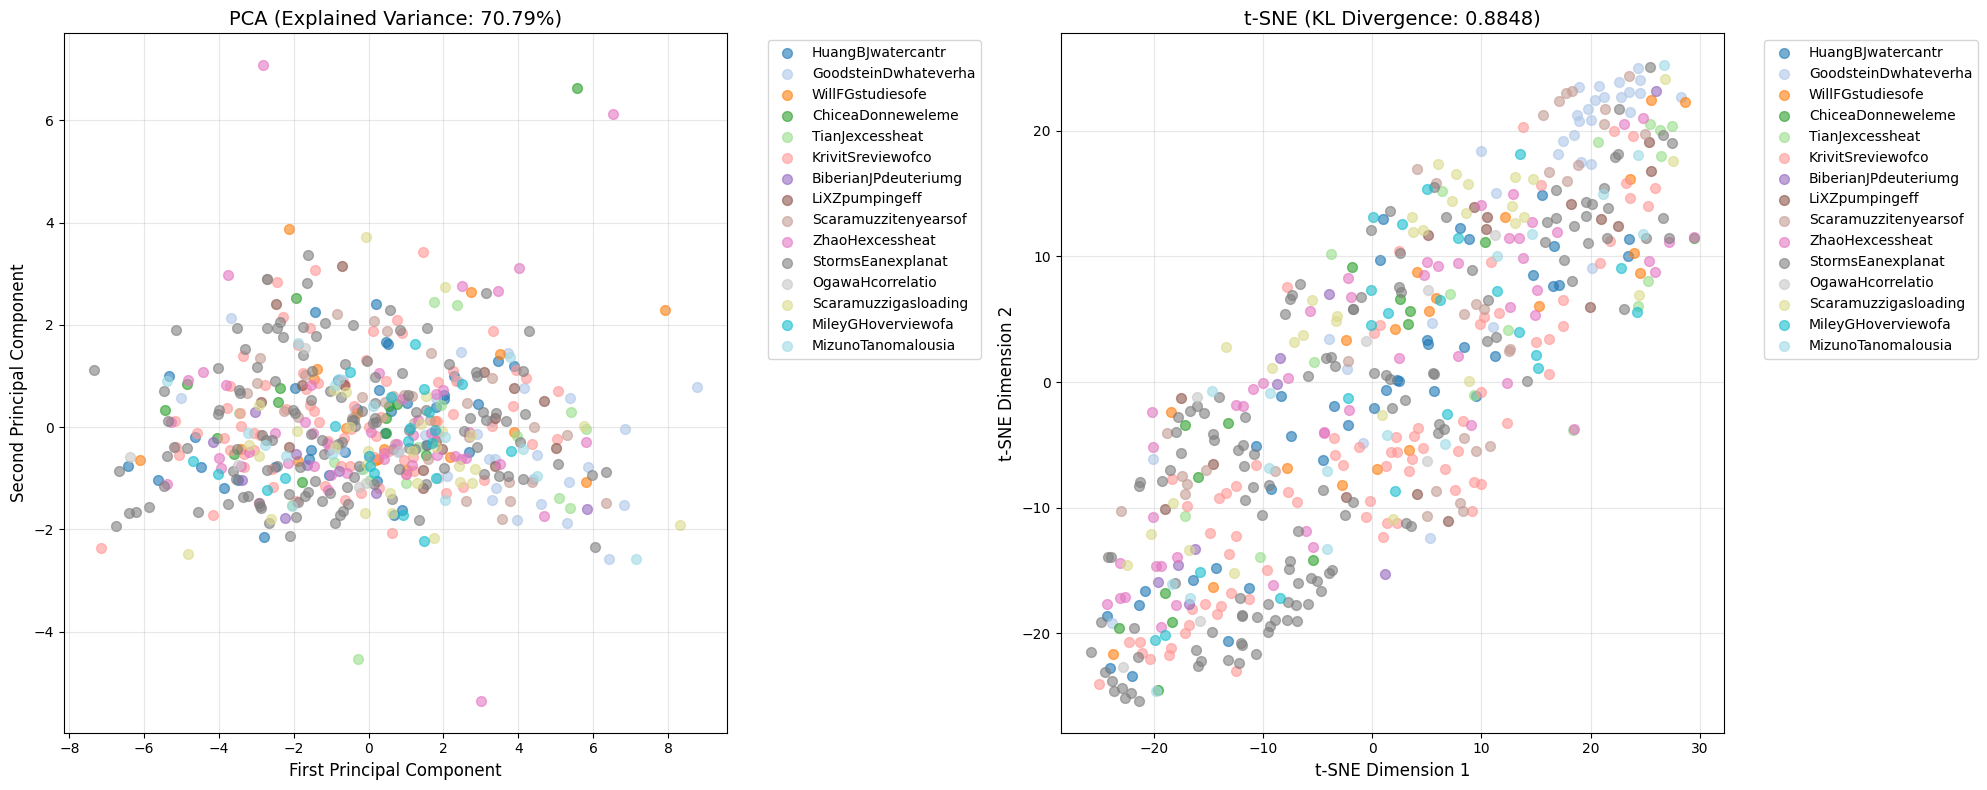

In [28]:
import pickle
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load the saved BERT embeddings
with open(GOOGLE_DRIVE_PATH/ 'bert_embeddings.pkl', 'rb') as f:
    embeddings_data = pickle.load(f)

# Extract embeddings and metadata
embeddings = embeddings_data['embeddings']
metadata = embeddings_data['metadata']

print(f"Original embedding shape: {embeddings.shape}")
print(f"Total chunks: {len(metadata)}")

# ============================================================================
# PCA REDUCTION
# ============================================================================
print("\n" + "="*80)
print("PERFORMING PCA REDUCTION")
print("="*80)

pca = PCA(n_components=2)
embeddings_2d_pca = pca.fit_transform(embeddings)

print(f"Reduced embedding shape: {embeddings_2d_pca.shape}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.4f}")

# Create PCA dataset
pca_data = []
for i, (x, y) in enumerate(embeddings_2d_pca):
    pca_data.append({
        'x': x,
        'y': y,
        'doc_name': metadata[i]['doc_name'],
        'chunk_index': metadata[i]['chunk_index'],
        'original_index': i
    })

# Save PCA results
pca_results = {
    'embeddings_2d': embeddings_2d_pca,
    'pca_data': pca_data,
    'metadata': metadata,
    'pca_model': pca,
    'explained_variance_ratio': pca.explained_variance_ratio_
}

with open(GOOGLE_DRIVE_PATH / 'bert_embeddings_pca_2d.pkl', 'wb') as f:
    pickle.dump(pca_results, f)

print(f"\nPCA results saved successfully!")

# ============================================================================
# t-SNE REDUCTION
# ============================================================================
print("\n" + "="*80)
print("PERFORMING t-SNE REDUCTION")
print("="*80)

# t-SNE parameters
tsne = TSNE(
    n_components=2,
    perplexity=30,  # Adjust based on dataset size (5-50 is typical)
    learning_rate=200,
    n_iter=1000,
    random_state=42,
    verbose=1
)

print("Running t-SNE (this may take a few minutes)...")
embeddings_2d_tsne = tsne.fit_transform(embeddings)

print(f"\nReduced embedding shape: {embeddings_2d_tsne.shape}")
print(f"Final KL divergence: {tsne.kl_divergence_:.4f}")

# Create t-SNE dataset
tsne_data = []
for i, (x, y) in enumerate(embeddings_2d_tsne):
    tsne_data.append({
        'x': x,
        'y': y,
        'doc_name': metadata[i]['doc_name'],
        'chunk_index': metadata[i]['chunk_index'],
        'original_index': i
    })

# Save t-SNE results
tsne_results = {
    'embeddings_2d': embeddings_2d_tsne,
    'tsne_data': tsne_data,
    'metadata': metadata,
    'kl_divergence': tsne.kl_divergence_
}

with open(GOOGLE_DRIVE_PATH / 'bert_embeddings_tsne_2d.pkl', 'wb') as f:
    pickle.dump(tsne_results, f)

print(f"\nt-SNE results saved successfully!")

# ============================================================================
# VISUALIZATION
# ============================================================================
print("\n" + "="*80)
print("CREATING VISUALIZATIONS")
print("="*80)

unique_docs = list(set([m['doc_name'] for m in metadata]))
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_docs)))
doc_to_color = {doc: colors[i] for i, doc in enumerate(unique_docs)}

# Create side-by-side comparison plot
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# PCA Plot
ax1 = axes[0]
for doc_name in unique_docs:
    doc_indices = [i for i, m in enumerate(metadata) if m['doc_name'] == doc_name]
    doc_points = embeddings_2d_pca[doc_indices]
    ax1.scatter(doc_points[:, 0], doc_points[:, 1],
                c=[doc_to_color[doc_name]],
                label=doc_name,
                alpha=0.6,
                s=50)

ax1.set_xlabel('First Principal Component', fontsize=12)
ax1.set_ylabel('Second Principal Component', fontsize=12)
ax1.set_title(f'PCA (Explained Variance: {sum(pca.explained_variance_ratio_):.2%})', fontsize=14)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# t-SNE Plot
ax2 = axes[1]
for doc_name in unique_docs:
    doc_indices = [i for i, m in enumerate(metadata) if m['doc_name'] == doc_name]
    doc_points = embeddings_2d_tsne[doc_indices]
    ax2.scatter(doc_points[:, 0], doc_points[:, 1],
                c=[doc_to_color[doc_name]],
                label=doc_name,
                alpha=0.6,
                s=50)

ax2.set_xlabel('t-SNE Dimension 1', fontsize=12)
ax2.set_ylabel('t-SNE Dimension 2', fontsize=12)
ax2.set_title(f't-SNE (KL Divergence: {tsne.kl_divergence_:.4f})', fontsize=14)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Clustering

In [29]:
import pickle

# Load embeddings
with open(GOOGLE_DRIVE_PATH /'bert_embeddings_tsne_2d.pkl', 'rb') as f:
    data = pickle.load(f)

embeddings = data['embeddings_2d']
metadata = data['metadata']

print(f"Loaded {embeddings.shape[0]} embeddings with dimension {embeddings.shape[1]}")

Loaded 510 embeddings with dimension 2



=== K-Means Clustering ===


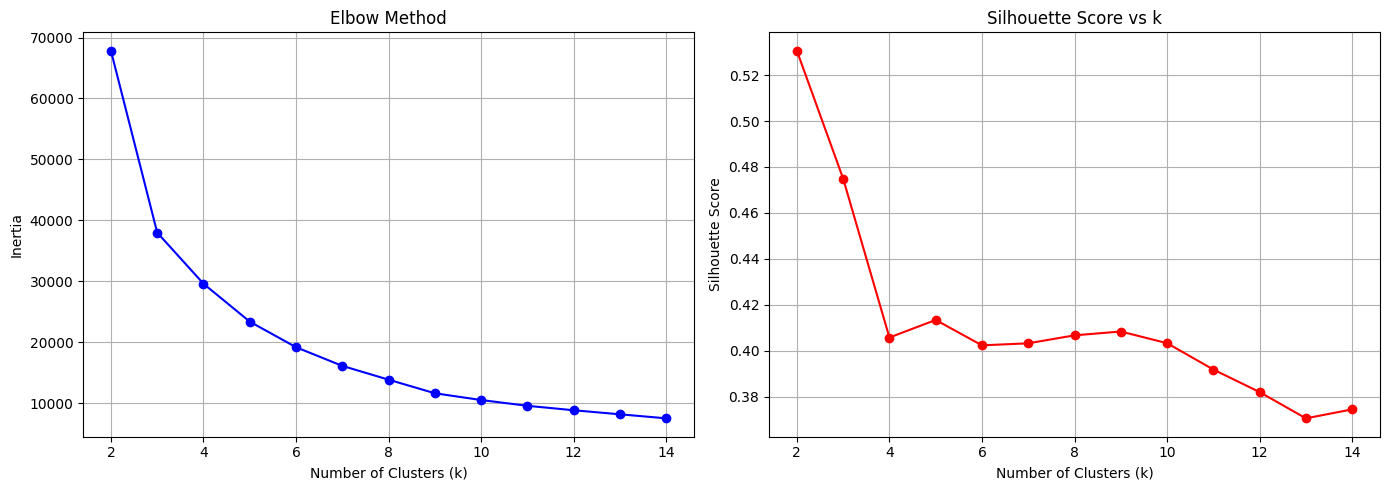

In [30]:
import numpy as np
import torch
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


# K-Means Clustering
print("\n=== K-Means Clustering ===")

# Find optimal number of clusters using elbow method
inertias = []
silhouette_scores = []
K_range = range(2, 15)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(embeddings)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(embeddings, labels))

# Plot elbow curve
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, 'ro-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs k')
plt.grid(True)

plt.tight_layout()
plt.show()


*   From the Elbow Method, the optimal value of k appears to be around 3, 4, or 5, as that’s where the “elbow” in the curve begins to form.
*   Based on the Silhouette Score, which is highest at k = 3, we select 3 as the optimal number of clusters.



In [31]:
optimal_k = 3  # Adjust based on elbow plot
print(f"\nUsing k={optimal_k} clusters")

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(embeddings)

# Add cluster labels to metadata
for i, meta in enumerate(metadata):
    meta['cluster'] = int(kmeans_labels[i])

print(f"Silhouette Score: {silhouette_score(embeddings, kmeans_labels):.4f}")
print(f"Davies-Bouldin Score: {davies_bouldin_score(embeddings, kmeans_labels):.4f}")



Using k=3 clusters
Silhouette Score: 0.4750
Davies-Bouldin Score: 0.7240


In [32]:
# DBSCAN (Density-Based)
print("\n=== DBSCAN Clustering ===")

dbscan = DBSCAN(eps=0.003, min_samples=3, metric='cosine')
dbscan_labels = dbscan.fit_predict(embeddings)

n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"Number of clusters: {n_clusters_dbscan}")
print(f"Number of noise points: {n_noise}")


=== DBSCAN Clustering ===
Number of clusters: 9
Number of noise points: 4



Optimal k for Hierarchical: 2


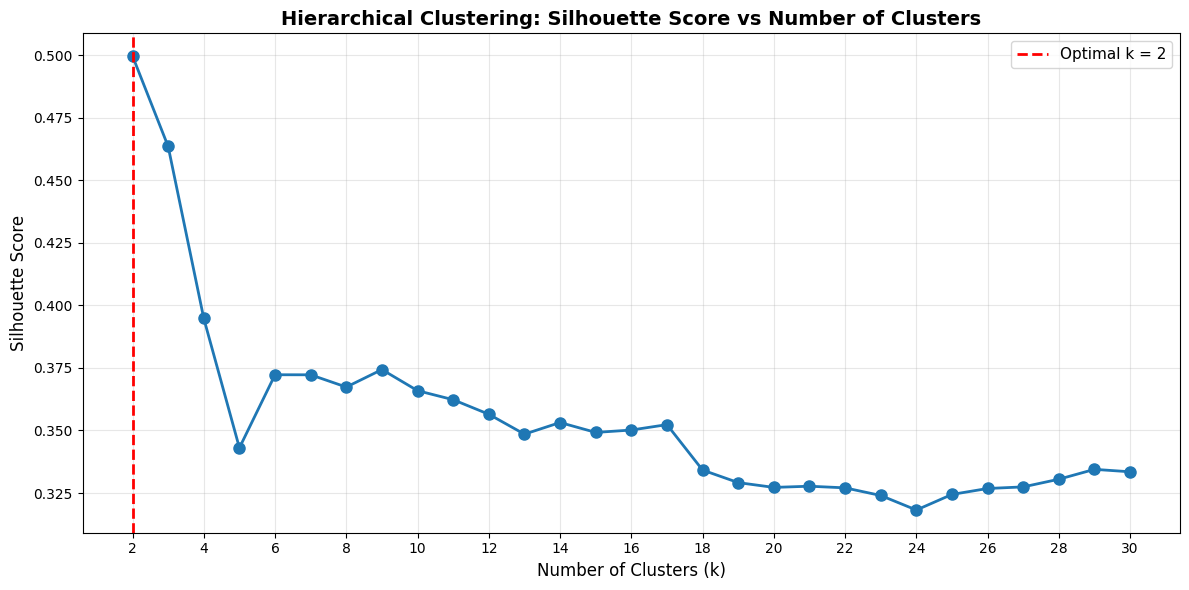


Optimal number of clusters: 2
Best Silhouette Score: 0.4996


In [33]:
# Test multiple k values
silhouette_scores = []
k_range = range(2, 31)

for k in k_range:
    hierarchical = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = hierarchical.fit_predict(embeddings)
    score = silhouette_score(embeddings, labels)
    silhouette_scores.append(score)

# Find optimal k for hierarchical
optimal_k_hierarchical = k_range[np.argmax(silhouette_scores)]
print(f"\nOptimal k for Hierarchical: {optimal_k_hierarchical}")

# Fit with optimal k and save labels
hierarchical = AgglomerativeClustering(n_clusters=optimal_k_hierarchical, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(embeddings)

# Plot silhouette scores for different k values
plt.figure(figsize=(12, 6))
plt.plot(list(k_range), silhouette_scores, marker='o', linewidth=2, markersize=8)
plt.axvline(x=optimal_k_hierarchical, color='red', linestyle='--', linewidth=2,
            label=f'Optimal k = {optimal_k_hierarchical}')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Hierarchical Clustering: Silhouette Score vs Number of Clusters', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.xticks(range(2, 31, 2))
plt.tight_layout()
plt.show()

# Print optimal k
print(f"\nOptimal number of clusters: {optimal_k_hierarchical}")
print(f"Best Silhouette Score: {max(silhouette_scores):.4f}")

Loaded 2D embeddings shape: (510, 2)
Total data points: 510

=== Visualizing Clusters ===


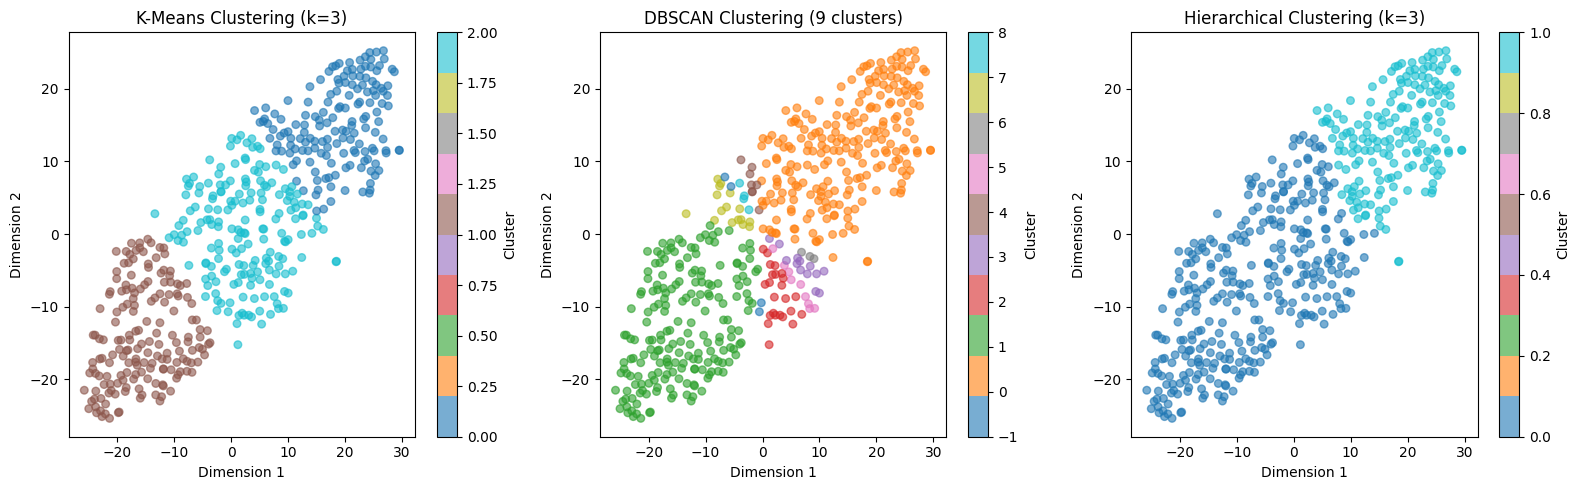


Cluster visualization saved successfully!

=== Cluster Distribution ===
K-Means: [156 171 183]
DBSCAN: [231 198  24  13   8   9   3  16   4] (excluding noise)
Hierarchical: [332 178]


In [35]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

# Load the 2D embeddings from your PCA results
with open(GOOGLE_DRIVE_PATH/'bert_embeddings_tsne_2d.pkl', 'rb') as f:
    pca_results = pickle.load(f)

embeddings_2d = pca_results['embeddings_2d']
metadata = pca_results['metadata']

print(f"Loaded 2D embeddings shape: {embeddings_2d.shape}")
print(f"Total data points: {len(embeddings_2d)}")

# ===== Visualize Clusters =====
print("\n=== Visualizing Clusters ===")

# Plot K-Means clusters
plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                     c=kmeans_labels, cmap='tab10', alpha=0.6, s=30)
plt.colorbar(scatter, label='Cluster')
plt.title(f'K-Means Clustering (k={optimal_k})')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Plot DBSCAN clusters
plt.subplot(1, 3, 2)
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                     c=dbscan_labels, cmap='tab10', alpha=0.6, s=30)
plt.colorbar(scatter, label='Cluster')
plt.title(f'DBSCAN Clustering ({n_clusters_dbscan} clusters)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Plot Hierarchical
plt.subplot(1, 3, 3)
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                     c=hierarchical_labels, cmap='tab10', alpha=0.6, s=30)
plt.colorbar(scatter, label='Cluster')
plt.title(f'Hierarchical Clustering (k={optimal_k})')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

plt.tight_layout()
plt.show()

print("\nCluster visualization saved successfully!")

# Optional: Print cluster distribution
print("\n=== Cluster Distribution ===")
print(f"K-Means: {np.bincount(kmeans_labels)}")
print(f"DBSCAN: {np.bincount(dbscan_labels[dbscan_labels >= 0])} (excluding noise)")
print(f"Hierarchical: {np.bincount(hierarchical_labels)}")

# Cluster Analysis Comparison and Rationale

The analysis compared three clustering algorithms—**DBSCAN**, **Hierarchical**, and **K-Means**—to identify the most practical model for topic modeling.

**DBSCAN:**  
DBSCAN proved difficult to tune; initial parameters(eps=5, min_samples=5) produced one large cluster, and even after adjusting to a very small `eps` value, it generated several clusters with many noise points. While it visually captured non-spherical, natural groupings better than other methods, the sensitivity to parameters and inconsistent cluster formation made it unreliable for consistent topic modeling.

**Hierarchical Clustering:**  
Hierarchical clustering achieved the best **Silhouette Score** at **k=2**, indicating two statistically optimal clusters. However, the results at k=3—though visually uniform—did not align well with the project’s goal of identifying multiple distinct topics, making it less suitable for fine-grained interpretation.

**K-Means Clustering:**  
K-Means with **k=3** produced visually balanced and interpretable clusters despite forcing spherical boundaries. Although its Silhouette Score was slightly lower than Hierarchical Clustering, it provided a clear, manageable structure aligned with the goal of differentiating between multiple topic areas.

**Conclusion:**  
While Hierarchical Clustering was statistically superior at k=2, **K-Means (k=3)** was chosen as the most practical approach. It offered a better balance between interpretability and utility, enabling the creation of three meaningful topic clusters that support the downstream goal of topic modeling more effectively.


## Extract Top Key Words

In [38]:
import pickle, json
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# ==== Load data ====
with open(GOOGLE_DRIVE_PATH / "bert_embeddings_tsne_2d.pkl", "rb") as f:
    pca_results = pickle.load(f)

embeddings_2d = pca_results["embeddings_2d"]
metadata = pca_results["metadata"]

with open(GOOGLE_DRIVE_PATH / "cleaned_doc_chunks.json", "r", encoding="utf-8") as f:
    cleaned_doc_chunks = json.load(f)

print(f"Loaded {len(metadata)} chunks")

# ==== Build full corpus ====
all_texts = []
for m in metadata:
    doc, idx = m["doc_name"], m["chunk_index"]
    if doc in cleaned_doc_chunks and idx < len(cleaned_doc_chunks[doc]):
        text = cleaned_doc_chunks[doc][idx].strip()
        if text:
            all_texts.append(text)

# ==== Fit TF-IDF ====
print("Fitting global TF-IDF for Unigram...")
vectorizer = TfidfVectorizer(
    stop_words="english",
    max_df=0.8,
    min_df=2,
    ngram_range=(1, 1),
    token_pattern=r"(?u)\b\w\w\w+\b"   # only words with 3+ characters

)
tfidf_matrix = vectorizer.fit_transform(all_texts)
feature_names = np.array(vectorizer.get_feature_names_out())

# ==== Extract keywords per cluster ====
tfidf_keywords = {}
for cid in range(optimal_k):
    cluster_mask = (kmeans_labels == cid)
    if not np.any(cluster_mask):
        tfidf_keywords[cid] = []
        continue

    # Average TF-IDF scores per term in this cluster
    cluster_mean = tfidf_matrix[cluster_mask].mean(axis=0).A1
    other_mean = tfidf_matrix[~cluster_mask].mean(axis=0).A1

    # Distinctiveness score
    distinctiveness = cluster_mean - other_mean
    top_idx = np.argsort(distinctiveness)[-6:][::-1]
    top_terms = feature_names[top_idx]
    tfidf_keywords[cid] = top_terms.tolist()

    print(f"Cluster {cid}: {', '.join(top_terms)}")


Loaded 510 chunks
Fitting global TF-IDF for Unigram...
Cluster 0: temperature, franco, experiment, heat, gas, power
Cluster 1: international, italy, conference, fusion, matter, nite
Cluster 2: deuterium, proceeding, research, reaction, low, product


In [39]:
# ==== Fit TF-IDF ====
print("Fitting global TF-IDF for Bi-gram...")
vectorizer = TfidfVectorizer(
    stop_words="english",
    max_df=0.8,
    min_df=2,
    ngram_range=(2, 2),
    token_pattern=r"(?u)\b\w\w\w+\b"   # only words with 3+ characters

)
tfidf_matrix = vectorizer.fit_transform(all_texts)
feature_names = np.array(vectorizer.get_feature_names_out())

# ==== Extract keywords per cluster ====
tfidf_keywords = {}
for cid in range(optimal_k):
    cluster_mask = (kmeans_labels == cid)
    if not np.any(cluster_mask):
        tfidf_keywords[cid] = []
        continue

    # Average TF-IDF scores per term in this cluster
    cluster_mean = tfidf_matrix[cluster_mask].mean(axis=0).A1
    other_mean = tfidf_matrix[~cluster_mask].mean(axis=0).A1

    # Distinctiveness score
    distinctiveness = cluster_mean - other_mean
    top_idx = np.argsort(distinctiveness)[-6:][::-1]
    top_terms = feature_names[top_idx]
    tfidf_keywords[cid] = top_terms.tolist()

    print(f"Cluster {cid}: {', '.join(top_terms)}")


Fitting global TF-IDF for Bi-gram...
Cluster 0: excess heat, press conference, positive result, hot fusion, mass loss, light water
Cluster 1: international conference, conference cold, nite energy, matter nuclear, nuclear science, conference condense
Cluster 2: nuclear reaction, low energy, proceeding international, energy nuclear, fusion technol, nuclear transmutation


In [48]:
print("Showing Top 3 documents for each clusters ")
# Extract top 3 documents per cluster
for cid in range(optimal_k):
    cluster_mask = (kmeans_labels == cid)
    if not np.any(cluster_mask):
        continue

    cluster_indices = np.where(cluster_mask)[0]
    cluster_center = kmeans.cluster_centers_[cid]
    distances = np.linalg.norm(embeddings_2d[cluster_indices] - cluster_center, axis=1)

    # Sort by distance and deduplicate by document name
    sorted_idx = cluster_indices[np.argsort(distances)]
    seen_docs = set()
    top_3_unique = []

    for doc_idx in sorted_idx:
        doc_name = metadata[doc_idx]["doc_name"]
        if doc_name not in seen_docs:
            seen_docs.add(doc_name)
            top_3_unique.append(doc_idx)
            if len(top_3_unique) == 3:
                break

    print(f"\nCluster {cid}:")
    for i, doc_idx in enumerate(top_3_unique, 1):
        doc_name = metadata[doc_idx]["doc_name"]
        chunk_idx = metadata[doc_idx]["chunk_index"]
        text = cleaned_doc_chunks[doc_name][chunk_idx].strip()
        print(f"  {i}. {doc_name} (chunk {chunk_idx}): {text[:150]}...")

Showing Top 3 documents for each clusters 

Cluster 0:
  1. StormsEanexplanat (chunk 31): particle obviously exist nature cause range behavior produce lenr observed rate explain remember generation power helium formation require helium atom...
  2. LiXZpumpingeff (chunk 10): effect reproduce day sec necessary power drop pumping jump power sec sec respectively different nature power jump sec setting computer require tpd jum...
  3. Scaramuzzitenyearsof (chunk 19): excess heat detect light water electrolysis experiment electrolysis patterson cell cathode constitute thousand small plastic sphere coat layer palladi...

Cluster 1:
  1. MileyGHoverviewofa (chunk 5): case observed element lanthanide group include lu tb pr eu sm gd dy ho nd yb widely accept rare earth element likely find impurity strengthen confiden...
  2. BiberianJPdeuteriumg (chunk 3): peo contain deuteriate phosphoric acid deuteron conductor pd cathode solid state electrolyte palladium anode electrolyte lithium battery ope

## Build faiss index

Use the generated embeddings to build a FAISS index for efficient similarity search.


In [42]:
!pip install faiss-cpu transformers torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 28.1 MB/s eta 0:00:00


In [43]:
import faiss

# Get the dimensionality of the embeddings
embedding_dim = bert_embeddings_tensor.shape[1]

# Create a FAISS index (e.g., IndexFlatL2)
index = faiss.IndexFlatL2(embedding_dim)

# Add the embeddings to the index
index.add(bert_embeddings_tensor.numpy())

# Print the number of vectors in the index
print(f"Number of vectors in the FAISS index: {index.ntotal}")


Number of vectors in the FAISS index: 510


## Implement search function



In [49]:
def search_faiss_index(query_string: str, index: faiss.Index, metadata: list, k: int = 5):
    """
    Searches the FAISS index for the most relevant documents/paragraphs to a query.

    Args:
        query_string: The user's query string.
        index: The FAISS index.
        metadata: A list of dictionaries containing metadata for each indexed item.
        k: The number of nearest neighbors to retrieve.

    Returns:
        A list of dictionaries containing the metadata of the most relevant items.
    """
    # Preprocess the query string
    cleaned_query = clean_text(query_string)

    # Generate embedding for the cleaned query
    query_embedding = get_bert_embedding(cleaned_query)

    # Search the FAISS index
    # The search method expects a numpy array and the number of neighbors (k)
    distances, indices = index.search(query_embedding.numpy(), k)

    # Retrieve metadata for the nearest neighbors
    relevant_items = []
    for i in indices[0]:  # indices is a 2D array, we need the first row
        relevant_items.append(metadata[i])

    return relevant_items


## Implement question answering



In [50]:
from transformers import pipeline

# Instantiate a question answering pipeline
qa_pipeline = pipeline("question-answering", model="distilbert-base-cased-distilled-squad")

Device set to use cuda:0


In [51]:
def extract_answer_from_context(question: str, context: str):
    """
    Extracts the answer to a question from a given text context using a QA pipeline.

    Args:
        question: The question to answer.
        context: The text containing the potential answer.

    Returns:
        The extracted answer as a string.
    """
    if not context.strip():
        return "No context provided."

    try:
        # Use the question answering pipeline to find the answer
        result = qa_pipeline(question=question, context=context)
        return result['answer']
    except Exception as e:
        print(f"Error extracting answer: {e}")
        return "Could not extract an answer."


In [61]:
def answer_question_with_faiss(question: str, k: int = 5):
    """
    Answers a question by searching a FAISS index and extracting the answer from retrieved text.

    Args:
        question: The user's question string.
        k: The number of relevant paragraphs to retrieve.

    Returns:
        The extracted answer as a string.
    """
    # Search the FAISS index for relevant paragraphs
    relevant_items = search_faiss_index(question, index, metadata, k)

    # Combine the text of the relevant paragraphs
    combined_context = ""
    for item in relevant_items:
        doc_name = item['doc_name']
        paragraph_index = item['chunk_index']
        # Ensure the document and paragraph index exist in para_docs_text
        if doc_name in cleaned_doc_chunks and paragraph_index < len(cleaned_doc_chunks[doc_name]):
            combined_context += cleaned_doc_chunks[doc_name][paragraph_index] + "\n"

            print(f"Retrieved from {doc_name} (chunk {paragraph_index})")
            print(f"Context: {cleaned_doc_chunks[doc_name][paragraph_index]}\n")




    # Extract the answer from the combined context
    answer = extract_answer_from_context(question, combined_context)

    return answer


In [68]:
questions = [
    "What does low energy nuclear reaction not act like?", # from cluster 1, StormsEanexplanat PDF
    "What process does not act like conventional hot fusion?", # from cluster 1, StormsEanexplanat PDF
    "Water can trigger what kind of reaction to produce energy?", # from cluster 2, HuangBJwatercantr PDF
    "It is suspected that Ne and CO2 is from what reaction of water?"
]

In [69]:
for question in questions:
  print("="*50)
  print(f"Question: {question}")
  answer = answer_question_with_faiss(question, k=3)
  print(f"Answer: {answer}")

Question: What does low energy nuclear reaction not act like?
Retrieved from StormsEanexplanat (chunk 114)
Context: chien electrode produce massive quantity tritium helium electroanal chem schwinger cold fusion hypothesis naturforsch fiarman meyerhof energy level light nucleus

Retrieved from ZhaoHexcessheat (chunk 31)
Context: short term fluctuation stf vcell pin result bad electrode configuration high current electrochemical calorimetric parameter electrolysis pd exp strictly speak electrolysis present narrow space stable wide cell electrolysis gas bubble produce grow break surface electrode process vcell pin increase maximum value bubble break

Retrieved from StormsEanexplanat (chunk 78)
Context: nauk sssr fiz khim russian yasui fractofusion mechanism fusion technol jabon fedorovich samsonenko catalitically induce fusion ferroelectric braz phy

Answer: fusion ferroelectric braz phy
Question: What process does not act like conventional hot fusion?
Retrieved from MileyGHoverviewofa (c